## Overview
What are LLMs?

Large language models (LLMs) are deep learning models trained on massive datasets of text. LLMs can translate language, summarize text, generate creative writing, generate code, power chatbots and virtual assistants, and complement search engines and recommendation systems.

### PaLM
PaLM 2 is Google's next generation large language model announced during Google I/O 2023 Conference.

### Vertex AI PaLM API
The Vertex AI PaLM API, released on May 10, 2023, is powered by PaLM 2.



### Data security

* Google does not use customer data to improve foundation models. Customer data is only used to generate a response from the model.

* Google employees have no access to customer data and all data is encrypted in-transit, in-use, and at-rest.

* Google does not store customer data. However, Google may temporarily cache customer data for the duration of the request, such as prompt tuning pipeline and batch prediction.

* Google does not log customer data. System-level logs help Google ensure system health and availability.

In [1]:
from google.colab import auth
auth.authenticate_user()

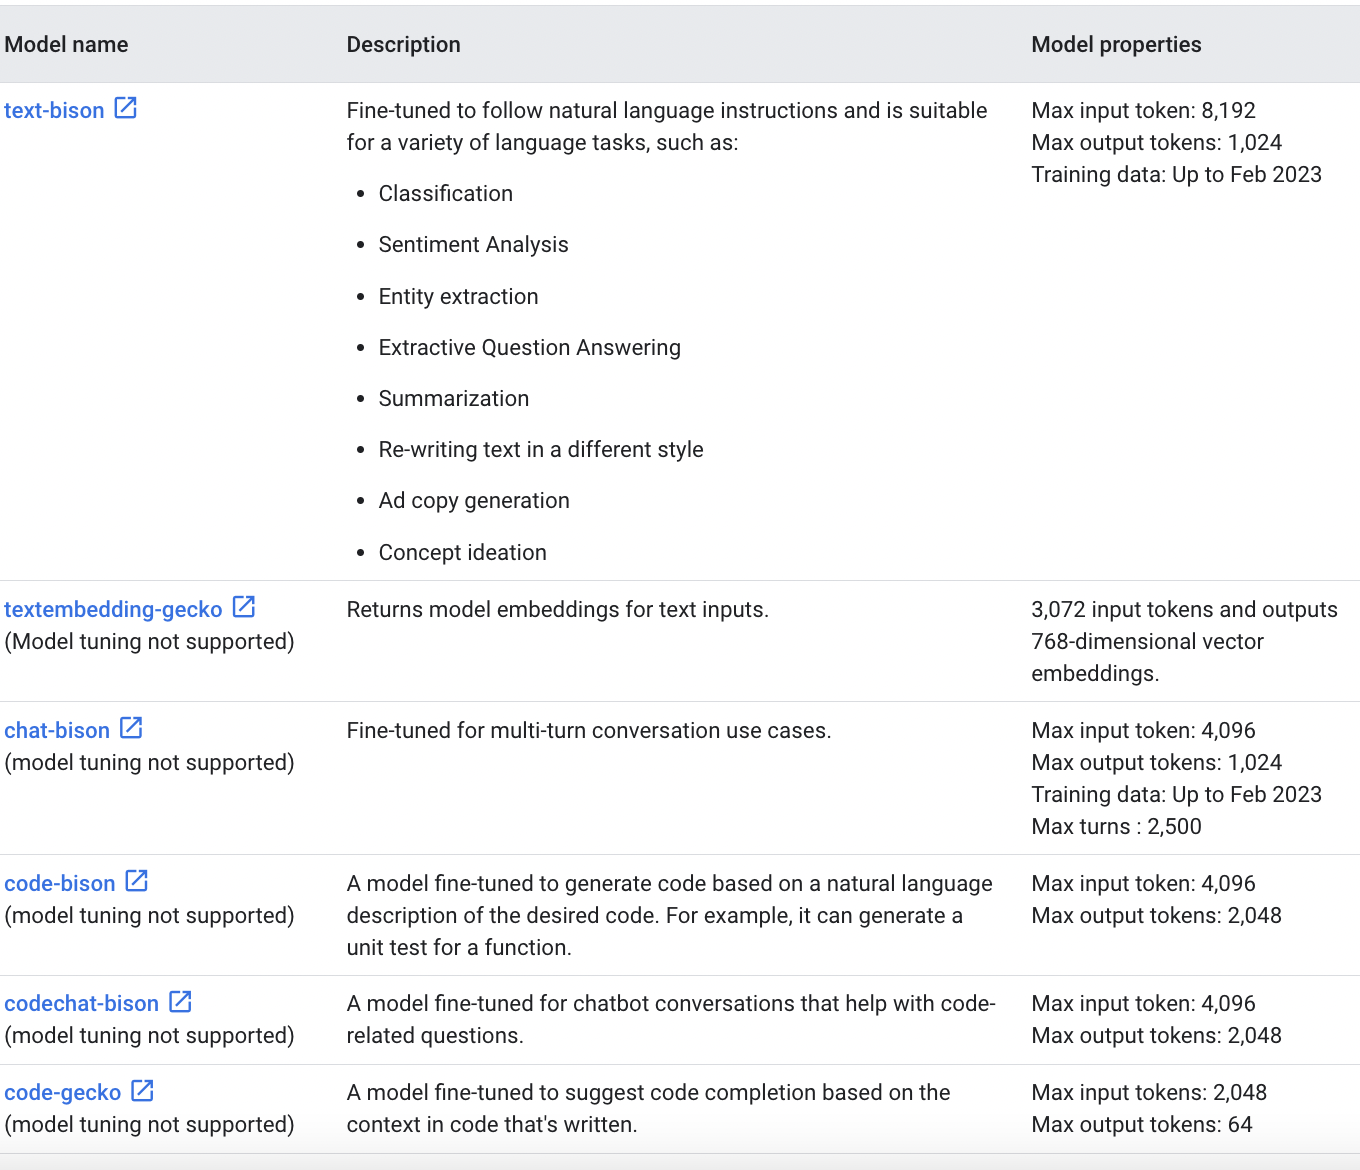

### Pricing

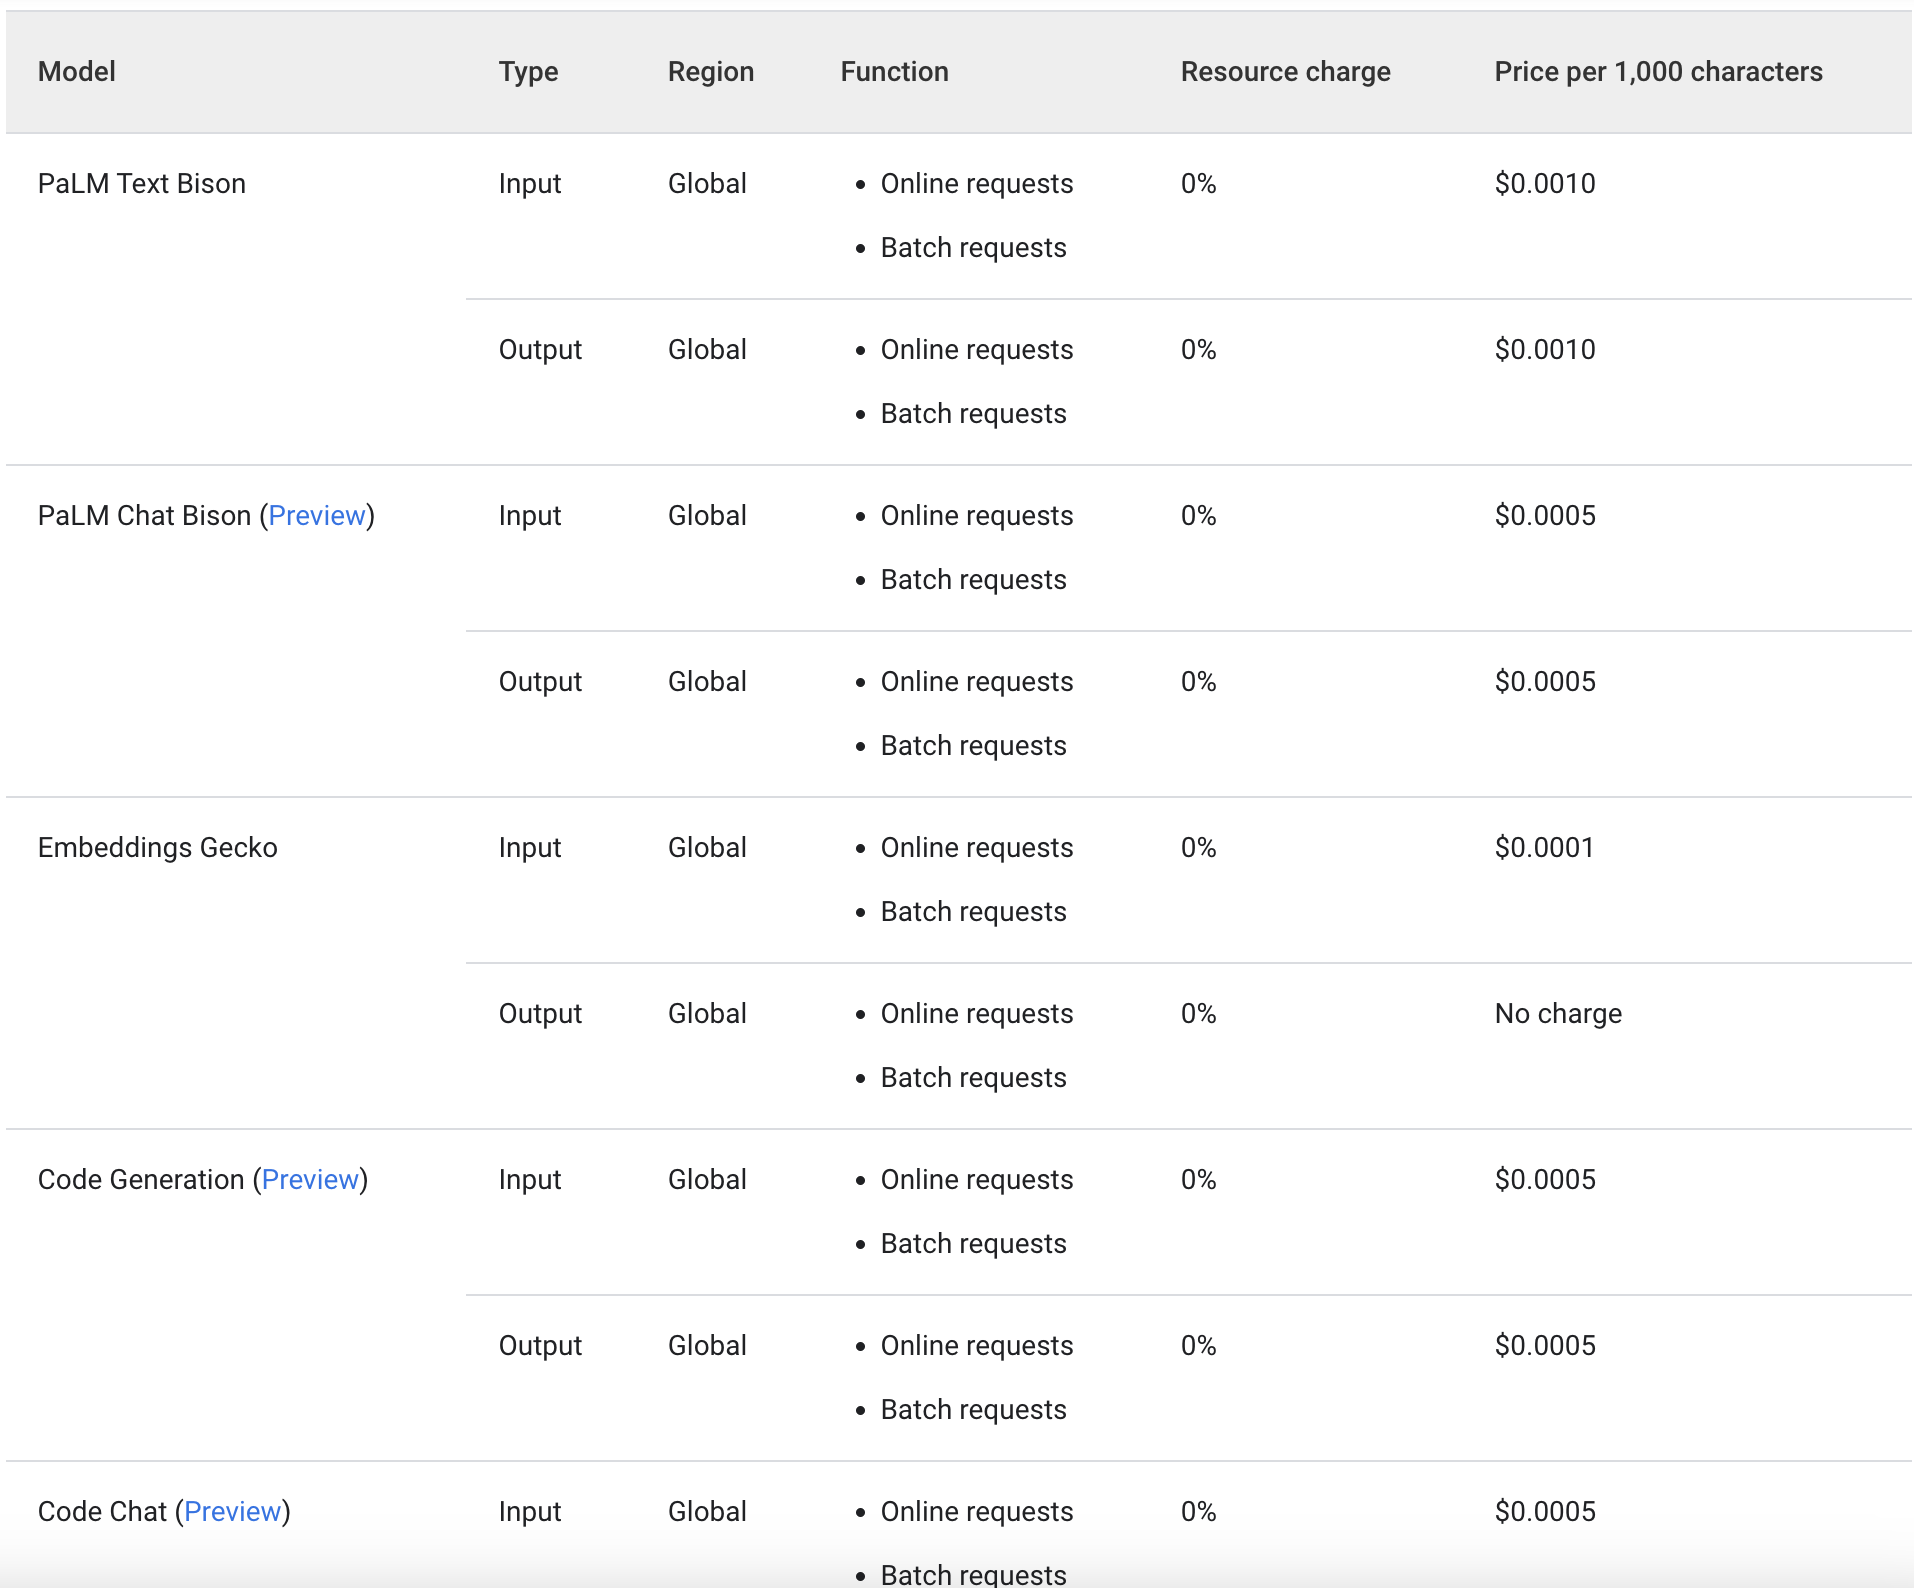

In [2]:
import vertexai

PROJECT_ID = "gen-ai-389722"
REGION = "us-central1"

vertexai.init(project=PROJECT_ID, location=REGION)

In [5]:
from IPython.display import Markdown, display
from vertexai.preview.language_models import TextEmbeddingModel, TextGenerationModel, CodeGenerationModel

In [8]:
generation_model = TextGenerationModel.from_pretrained("text-bison@001")
embedding_model = TextEmbeddingModel.from_pretrained("textembedding-gecko@001")
code_generation_model = CodeGenerationModel.from_pretrained("code-bison@001")

Need to enable Vertex AI API
https://console.cloud.google.com/apis/library/aiplatform.googleapis.com

Temperature = 0 is deterministic

The higher temperature, the more likely hallucinations will be produced

In [ ]:
prompt = """
  Please finish the sentence in an abstract way.
  The small rabbit is
"""
temperature = 0.0
response = generation_model.predict(prompt=prompt, temperature=temperature)
print(f"Temperature={temperature}")
print(response.text)

Temperature=0.0
The small rabbit is a small animal. It is a small animal that is cute and fluffy. It is a small animal that is playful and curious. It is a small animal that is a good pet.


In [ ]:
prompt = """
  Please finish the sentence in an abstract way.
  The small rabbit is
"""
temperature = 1.0
response = generation_model.predict(prompt=prompt, temperature=temperature)
print(f"Temperature={temperature}")
print(response.text)

Temperature=1.0
The small rabbit is a symbol of hope and renewal.
The small rabbit is a survivor.
The small rabbit is a reminder that even in the darkest of times, there is always hope.


In [ ]:
prompt = """
  What are the best programming languages recommended for young person passionate with data?
  Please provide TOP 3 languages and list only 1 distint feature of each.
  Please reply with the YAML-compatible structure as shown below.

  Example:
  - name: NewLanguage 1
    features:
      - fast and reliable
  - name: NewLanguage 2
    features:
      - easy to learn
"""

response = generation_model.predict(prompt=prompt, temperature=0.2)

display(Markdown(response.text))

```
- name: Python
  features: 
    - versatile and easy to learn
- name: R
  features: 
    - powerful statistical analysis
- name: SQL
  features: 
    - structured query language for data management
```

### QA on large PDF documents
Analyse Alphabet 10-k report.

In [ ]:
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.vectorstores import FAISS
import time

In [ ]:
loader = PyPDFLoader("20230203_alphabet_10K.pdf")
splits = loader.load_and_split()

In [ ]:
print(f"Nr of Pages={len(splits)}")

Nr of Pages=128


In [ ]:
# text_splitter = CharacterTextSplitter(chunk_size=1000)
# splits = text_splitter.split_documents(pages)

In [ ]:
class VertexAIEmbeddings:
  """
  Embeddings class required by langchain needs to implement methods:
    1. embed_documents
    2. embed_query
  """

  def __init__(self, embeddings_model):
      self.embeddings_model = embeddings_model

  def embed_documents(self, texts: str):
    embeddings = []

    for i, text in enumerate(texts):
      if i % 50 == 0:
        print(i)

      embeddings.append(self.embeddings_model.get_embeddings([text])[0].values)
      # Due to API rate limits, need to sleep between requests.
      # Hopefully, these restrictions will be removed in the future
      time.sleep(3)

    return embeddings

  def embed_query(self, text: str):
    return self.embeddings_model.get_embeddings([text])[0].values

In [ ]:
db = FAISS.from_texts([doc.page_content for doc in splits], VertexAIEmbeddings(embedding_model))

0
50
100


In [ ]:
def get_answer(db, query: str, max_output_tokens=200, k=5) -> str:
    """
    Generates answer based on context retrieved from Vector Stroage.
    """

    most_similar_chunks = db.similarity_search_with_score(query, k)

    context = "\n".join([f'Context {i + 1}:\n' + doc[0].page_content for i, doc in enumerate(most_similar_chunks)])

    prompt = f"""
        Use the following pieces of context to answer the question at the end.
        Please use the third person.
        If you don't know the answer, just say that you don't know, don't try to make up an answer.

        {context}

        Question:
        {query}

        Answer:
    """

    response = generation_model.predict(prompt, temperature=0, max_output_tokens=max_output_tokens)
    return response

In [ ]:
get_answer(db, "What is the total revenue of Alphabet as compared to last year?", k=2)

The total revenue of Alphabet as compared to last year is $282.8 billion, an increase of 10% year over year.

In [ ]:
get_answer(db, "What are the main competitors?", k=2)

Google's main competitors are:
    - general purpose search engines and information services
    - vertical search engines and e-commerce providers for queries related to travel, jobs, and health, which users may navigate directly to rather than go through Google
    - online advertising platforms and networks
    - other forms of advertising, such as billboards, magazines, newspapers, radio, and television as our advertisers typically advertise in multiple media, both online and offline
    - digital content and application platform providers
    - providers of enterprise cloud services
    - companies that design, manufacture, and market consumer hardware products, including businesses that have developed proprietary platforms
    - providers of digital video services
    - social networks, which users may rely on for product or service referrals, rather than seeking information through traditional search engines
    - providers of workspace communication and connectivity products
  

In [ ]:
get_answer(db, "List acquisitions in 2022", k=2)

In 2022, Alphabet Inc. acquired Mandiant for a total purchase price of $6.1 billion.

In [ ]:
get_answer(db, "What is the stock price?", k=5)

The stock price is $98.92 per share.

In [ ]:
get_answer(db, "What are the largest businesses of Alphabet?", k=5)

The largest businesses of Alphabet are Google Services and Google Cloud.

In [ ]:
get_answer(db, "How much did Google Cloud revenues change?", k=2)

Google Cloud revenues increased by $7,074 million from 2021 to 2022.

In [ ]:
get_answer(db, "How much was spent on capital expeditures?", k=2)

During the years ended December 31, 2021  and 2022 , Alphabet spent $24.6 billion  and $31.5 billion  on capital 
expenditures, respectively.

### Langchain
Abstract away processing to Langchain

In [ ]:
from langchain.chains.question_answering import load_qa_chain
from langchain.chains import RetrievalQA
from langchain.llms import VertexAI

llm = VertexAI()
qa = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff", retriever=db.as_retriever())

In [ ]:
query = "What is the total revenue of Alphabet as compared to last year?"
qa.run(query)

'The total revenue of Alphabet was $282.836 billion in 2022, which is an increase of 10% from the previous year.'

In [ ]:
query = "What are the main competitors?"
print(qa.run(query))

The main competitors are:
•general  purpose search engines and information services;
•vertical search engines and e-commerce providers for queries related to travel, jobs, and health, which users 
may navigate directly to rather than go through  Google ;
•online advertising platforms and networks;
•other forms of advertising, such as billboards, magazines, newspapers, radio, and television as our advertisers 
typically advertise in multiple media, both online and offline;
•digital content and application platform providers;
•providers of enterprise cloud services;
•companies that design, manufacture, and market consumer hardware products, including


In [ ]:
query = "List acquisitions in 2022"
print(qa.run(query))

In September 2022, we closed the acquisition of Mandiant for a total purchase price of $6.1 billion, including cash and debt. The purchase price excludes post acquisition compensation arrangements. Mandiant's dynamic cyber defense, threat intelligence and incident response services are expected to enhance Google Cloud's security offerings. The financial results of Mandiant have been included within the Google Cloud segment as of the close of the acquisition.


In [ ]:
query = "How much was spent on capital expeditures?"
print(qa.run(query))

During the years ended December 31, 2021  and 2022 , we spent $24.6 billion  and $31.5 billion  on capital 
expenditures, respectively.


In [18]:
prompt = """
  Create Python class that reads table dataset_name.table_name from BigQuery, extracts its schema, and dumps it to JSON local file.
  Create unit tests using pytest package.
"""

code_generation_model.predict(prefix=prompt, temperature=0.0, max_output_tokens=2000)

```python
import bq
import json

class BigQuerySchema:

    def __init__(self, dataset_name, table_name):
        self.dataset_name = dataset_name
        self.table_name = table_name

    def read_schema(self):
        """
        Reads the schema of the BigQuery table.

        Returns:
            A list of dictionaries, where each dictionary represents a column in the table.
        """
        # Get the table reference.
        table_ref = bq.dataset(self.dataset_name).table(self.table_name)

        # Get the schema.
        schema = table_ref.schema()

        # Return the schema as a list of dictionaries.
        return [
            {
                "name": field.name,
                "type": field.field_type,
                "mode": field.mode,
            }
            for field in schema
        ]

    def dump_schema(self, file_path):
        """
        Dumps the schema of the BigQuery table to a JSON file.

        Args:
            file_path: The path to the JSON file.